In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import h5py
import os

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import *



C:\Users\Emmett\AppData\Local\Temp\ipykernel_7308\3272948618.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def get_dlc_data(Tracking_sleep_data_path,name,interp,val):
    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(Tracking_sleep_data_path, 'h5')
    for file in TFiles_unsort:
        h5_read=pd.read_hdf(Tracking_sleep_data+file)
    # Access the head center      
    scorer =  h5_read.columns.tolist()[0][0]
    Task_body_centre =  h5_read[scorer][name]
    print(Task_body_centre)
    if interp:
        Task_body_centre=clean_and_interpolate(Task_body_centre,val)
        print(Task_body_centre)
        

    return  Task_body_centre

def get_distances(Task_body_centre_2):
    distance=[]
    for i, x in enumerate(Task_body_centre_2['interped_x'].values):
        if i== 0:
            x_vector_old = Task_body_centre_2['interped_y'].values[i]
            y_vector_old = Task_body_centre_2['interped_x'].values[i]
        else:
            x_vector_new = Task_body_centre_2['interped_y'].values[i]
            y_vector_new = Task_body_centre_2['interped_x'].values[i]
        
            distance_x = (x_vector_new -x_vector_old)**2 
            distance_y = (y_vector_new -y_vector_old)**2 
        
            distance.append(np.sqrt(distance_x + distance_y))
            y_vector_old = y_vector_new
            x_vector_old = x_vector_new
    distance.append(np.sqrt(distance_x + distance_y))   # Repeat the last row to have the same size vector     
    return distance

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(clock_head_centre,threshold):

    bad_confidence_inds = np.where(clock_head_centre.likelihood.values<threshold)[0]
    newx = clock_head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = clock_head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    clock_head_centre['interped_x'] = interped_x
    clock_head_centre['interped_y'] = interped_y
    
    return clock_head_centre

def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                   

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                 

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)



def get_csv_speed_align_time(Tracking_sleep_data,align_path,save):
    Task_body_centre=get_dlc_data(Tracking_sleep_data,'body_centre',False,0.9995)
    Task_body_centre_2=get_dlc_data(Tracking_sleep_data,'body_centre',True,0.9995)
    distances=get_distances(Task_body_centre_2)
    align = open(align_path, 'r')
    reader = csv.reader(align)
    headers = next(reader, None)
    column = {}
    for h in headers:
        column[h] = []
    for row in reader:
        for h, v in zip(headers, row):
            column[h].append(v)
    Camera_EPhys_aligned=np.array(column['Camera_time_Ephys_Aligned'])    
    align.close()
    fig, axs = plt.subplots(4, 1,figsize=(6, 15))
    axs[0].plot(Task_body_centre['x'].values,'o',color = 'blue',markersize=2)
    axs[0].plot(Task_body_centre_2['interped_x'].values,'o',color = 'red',markersize=1)
    axs[0].set_title('X')
    axs[1].plot(Task_body_centre['y'].values,'o',color = 'blue',markersize=2)
    axs[1].plot(Task_body_centre_2['interped_y'].values,'o',color = 'red',markersize=1)
    axs[1].set_title('Y')
    axs[2].plot(Task_body_centre['x'].values,Task_body_centre['y'].values,'o',color = 'blue',markersize=2)
    axs[2].plot(Task_body_centre_2['interped_x'].values,Task_body_centre_2['interped_y'].values,'o',color = 'red',markersize=1)
    axs[3].plot(distances,color = 'blue',markersize=2)
    df = pd.DataFrame({"v" : distances, "Ephys" : Camera_EPhys_aligned})
    df.to_csv(save, index=False)    
    return Camera_EPhys_aligned , distances


def get_sleep_video(post_process_directory,video_path,time_span_name,align_path):
    # Get EPhys times
    timefile=os.path.join(post_process_directory,"Time_intervales.txt")
    names, time_spans = [], []
    with open(timefile) as f:
        for (i, line) in enumerate(f.readlines()):
            [name, time_span] = line.split(',', 1)
            print(name,time_span)
            time_span = eval(time_span)
            names.append(name)
            time_spans.append(time_span)
    names = np.array(names)
    id = np.argwhere(names == time_span_name)[0][0]
    time_span = time_spans[id]
    time_spans=time_span[0]
    start_frame_time_Ephys = time_spans[0]
    end_frame_time_EPhys= time_spans[1]
    align = open(align_path, 'r')
    reader = csv.reader(align)
    headers = next(reader, None)
    column = {}
    for h in headers:
        column[h] = []
    for row in reader:
        for h, v in zip(headers, row):
            column[h].append(v)    
    align.close()
    if time_span_name == 'Post_sleep':
        video_save_name=post_process_directory + 'post_sleep_video.mp4'
         # Align to Camera time
        Camera_EPhys_aligned=np.array(column['Camera_time_Ephys_Aligned'])    
        Camera_time=np.array(column['Camera_time_raw'])   
        align.close()
        start_frame_time =Camera_time[np.argwhere(find_nearest(Camera_EPhys_aligned.astype(np.float),start_frame_time_Ephys)==Camera_EPhys_aligned.astype(np.float))[0]].astype(np.float)
        end_frame_time=Camera_time[np.argwhere(find_nearest(Camera_EPhys_aligned.astype(np.float),end_frame_time_EPhys)==Camera_EPhys_aligned.astype(np.float))[0]].astype(np.float)

    if time_span_name== 'Pre_sleep':
        video_save_name=post_process_directory + 'pre_sleep_video.mp4'
        # Align to Camera time 
        Camera_EPhys_aligned=np.array(column['Camera_time_Ephys_Aligned'])    
        Camera_time=np.array(column['Camera_time_raw'])   
        align.close()
        start_frame_time =Camera_time[np.argwhere(find_nearest(Camera_EPhys_aligned.astype(np.float),start_frame_time_Ephys)==Camera_EPhys_aligned.astype(np.float))[0]].astype(np.float)
        end_frame_time=Camera_time[np.argwhere(find_nearest(Camera_EPhys_aligned.astype(np.float),end_frame_time_EPhys)==Camera_EPhys_aligned.astype(np.float))[0]].astype(np.float)
        
    if time_span_name == 'Awake' :
        video_save_name=post_process_directory + 'awake_video.mp4' 
        Camera_EPhys_aligned=np.array(column['PokeIN_EphysTime'])    
        Camera_time=np.array(column['backcam_aligned_pokein_times'])   
        start_frame_time =Camera_time[np.argwhere(find_nearest(Camera_EPhys_aligned.astype(np.float),start_frame_time_Ephys)==Camera_EPhys_aligned.astype(np.float))[0]].astype(np.float)
        end_frame_time=Camera_time[np.argwhere(find_nearest(Camera_EPhys_aligned.astype(np.float),end_frame_time_EPhys)==Camera_EPhys_aligned.astype(np.float))[0]].astype(np.float)
        print(start_frame_time_Ephys)
        print(end_frame_time_EPhys)
        print(start_frame_time)
        print(end_frame_time)
   
    TFiles_unsort = list_files(video_path,'avi')
    for file in TFiles_unsort:
        if (file.find('above') != -1):
            avi_read=file
            print(file)
        if (file.find('back') != -1):
            avi_read=file
            print(file)
    cam_path_s = video_path + avi_read
   
   
    ffmpeg_extract_subclip(cam_path_s,start_frame_time,end_frame_time,targetname=video_save_name)
    return  start_frame_time    

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
                  

In [25]:
path = r"Z:\projects\sequence_squad\organised_data\animals\\"
animal = "EJT255_implant1"

recording1_04-14-2023
coords           x           y  likelihood
0       255.208817  537.896118    0.999979
1       255.090469  537.497498    0.999974
2       255.339172  537.211304    0.999975
3       255.279282  537.508545    0.999977
4       255.260849  537.408630    0.999976
...            ...         ...         ...
212954  244.054810  510.402435    0.999469
212955  244.070480  510.776672    0.999404
212956  244.174393  510.539673    0.999530
212957  244.240479  510.468842    0.999629
212958  244.125626  510.711212    0.999516

[212959 rows x 3 columns]
coords           x           y  likelihood
0       255.208817  537.896118    0.999979
1       255.090469  537.497498    0.999974
2       255.339172  537.211304    0.999975
3       255.279282  537.508545    0.999977
4       255.260849  537.408630    0.999976
...            ...         ...         ...
212954  244.054810  510.402435    0.999469
212955  244.070480  510.776672    0.999404
212956  244.174393  510.539673    0.999530
21295

coords           x           y  likelihood
0       161.238922  546.613525    0.999980
1       160.153671  547.805298    0.999982
2       160.123764  548.230835    0.999980
3       160.305573  548.068787    0.999982
4       160.345779  547.514954    0.999982
...            ...         ...         ...
219097    0.000000    0.000000    0.000000
219098    0.000000    0.000000    0.000000
219099    0.000000    0.000000    0.000000
219100    0.000000    0.000000    0.000000
219101    0.000000    0.000000    0.000000

[219102 rows x 3 columns]
function exiting
function exiting
coords           x           y  likelihood  interped_x  interped_y
0       161.238922  546.613525    0.999980  161.238922  546.613525
1       160.153671  547.805298    0.999982  160.153671  547.805298
2       160.123764  548.230835    0.999980  160.123764  548.230835
3       160.305573  548.068787    0.999982  160.305573  548.068787
4       160.345779  547.514954    0.999982  160.345779  547.514954
...            ...   

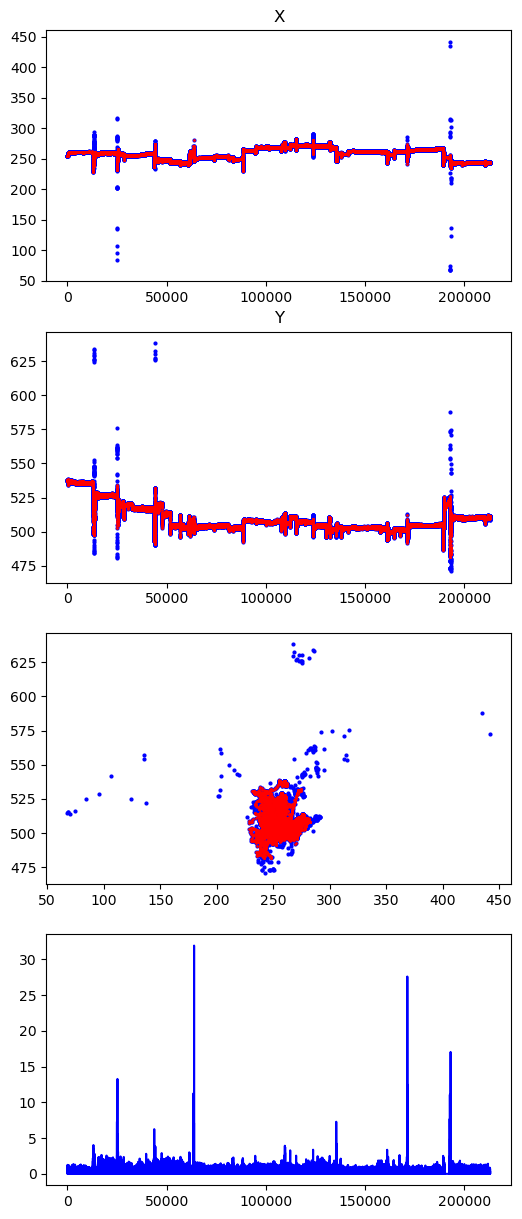

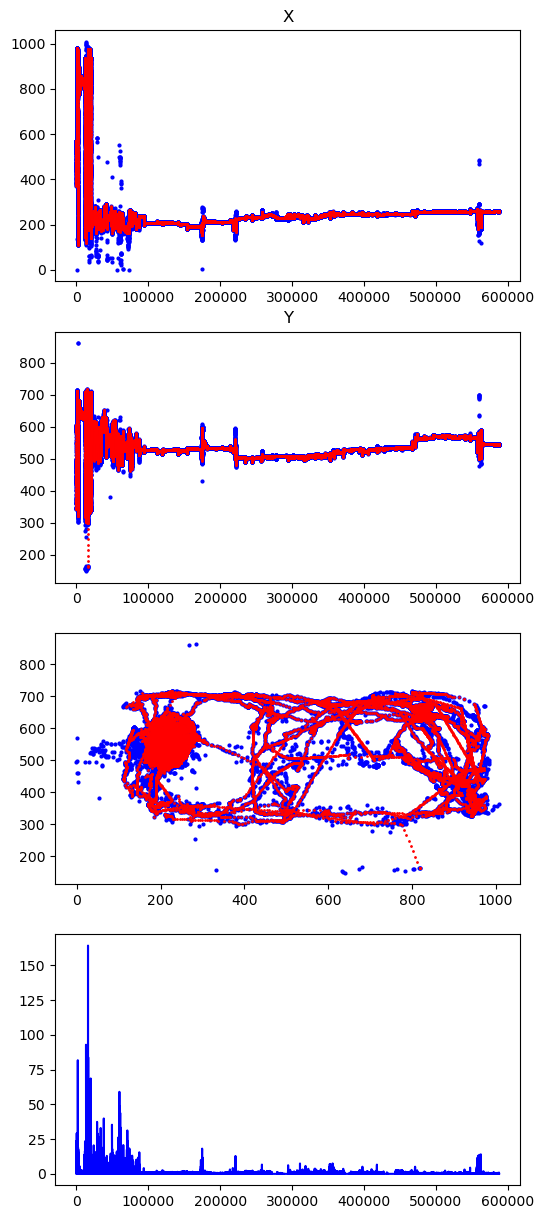

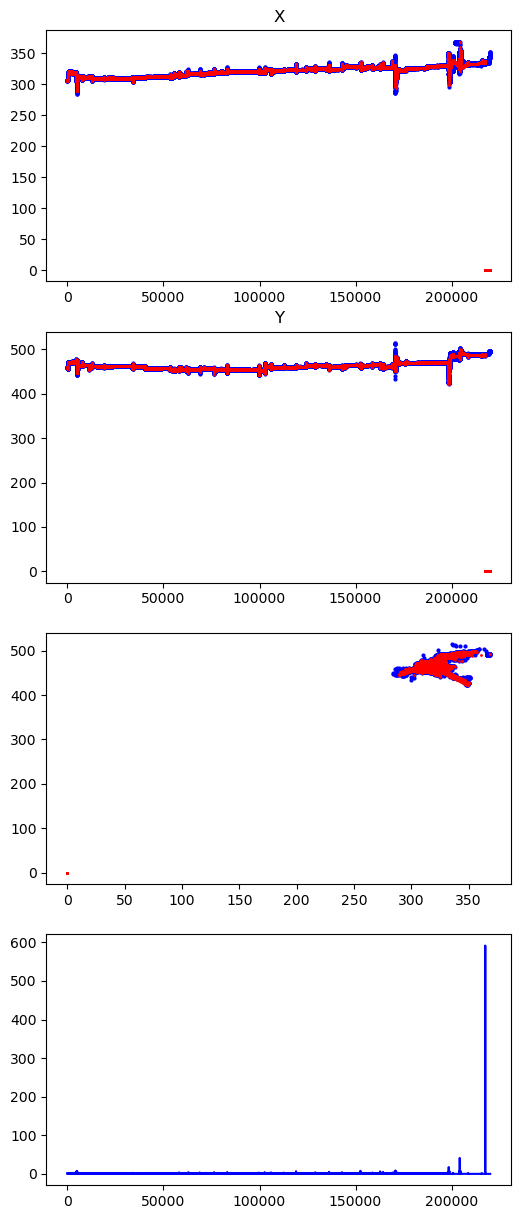

In [26]:
path_ = path+animal
for recording in os.listdir(path_):
    if not 'Store' in recording: # ignore ds store thing
        print(recording)
        current_path = os.path.join(path_,recording) + '\\'
        output_path = os.path.join(path_,recording,'post_process_ppseq') + '\\' 
        
        # presleep        
        video_path = os.path.join(current_path, r"video/videos/1_presleep//")
        Tracking_sleep_data = os.path.join(current_path, r"video/tracking/1_presleep//")
        align_path = os.path.join(current_path, r"behav_sync/1_pre_sleep//") + "Presleep_Ephys_Camera_sync.csv"
        
        try:
    #         start=get_sleep_video(output_path,video_path,'Pre_sleep',align_path)
            Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,output_path + 'velocity_mice_1_presleep.csv')
        except:
            print('no presleep?')
    
        # post sleep
        video_path = os.path.join(current_path, r"video/videos/3_postsleep//")
        Tracking_sleep_data = os.path.join(current_path, r"video/tracking/3_postsleep//")
        align_path = os.path.join(current_path, r"behav_sync/3_post_sleep//") + "Postsleep_Ephys_Camera_sync.csv"

        try:
    #         start=get_sleep_video(output_path,video_path,'Post_sleep',align_path)
            Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,output_path + 'velocity_mice_3_post_sleep.csv')       
        except:
            print('no postsleep')
        
        
        


In [ ]:


# Animal EJT178 Implant 1 Awake, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


#presleep
# Animal EJT178 Implant 1 postsleep, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# How to run for a new animal.

I am sorry this is quite un-optimal due to development at the same time as other part of the code. If I get the time I will try to make this better.

    0. Gather the paths of the animal of interest and the section of interest (pre_sleep, awake, post_sleep).
        (video_sleep_data = where the video is,saved_path_2 = where the new video will be saved, 
     Tracking_sleep_data =where the deeplab cut tracking is.'alignn_path 
     saved_path 
    1. For each section run : Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
        This will give you the postprocess velocity of the animal in a csv file, aligned with the Ephys)
    2. Make sure that there is the performance score in the folder (Ask Emmette)
    3. Run prepare data to get the prepare_data.png (the fiering rate, poke time, performance score, and if present the velocities)
       (see repo prepare_data_new.py --visualisation True -- 178_1_2)
    4. From this create a Time_intervalles.txt file with the time interval (pre_sleep,Post_sleep,Awake) of interest to be fed to ppseq prep_date. 
        (Respect the format shown in the other animal files)(Time interval should be chosen to be 600s long for awake at a perf score above 0.8 )
       (For Sleep find a time interval where the fiering rate and the velocity is low)
               5. Finally, check using videos that the behavior in each section is has expected. by running start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)


In [8]:
# TEST
# Selected by Emmete

# Animal EJT178 Implant 1 Awake, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/2_task/Behav_Ephys_Camera_Sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# EJT149 recording 1 
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/behav_sync/2_task/Behav_Ephys_Camera_Sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# EJT162 recording 3
videos_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/videos/2_task/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/behav_sync/2_task/Behav_Ephys_Camera_Sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)


# EJT178_implant 2 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/videos/2_task/' 
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/behav_sync/2_task/Behav_Ephys_Camera_Sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)


# EJT48 implant 2 recording 2
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/videos/2_task/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/behav_sync/2_task/Behav_Ephys_Camera_Sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# EJT149_implant2 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/video/videos/2_task/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/post_process_ppseq/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/behav_sync/2_task/Behav_Ephys_Camera_Sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Selected by Emmettw
######################################################################################################################
# Animal EJT178 Implant 1 Awake, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


# EJT149 recording 1 
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

# EJT162 recording 3
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/videos/1_presleep/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/tracking/1_presleep/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


# EJT178_implant 2 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/videos/1_presleep/' 
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/tracking/1_presleep/' 
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

# EJT48 implant 2 recording 2
# saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/'
# video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/videos/1_presleep/'
# Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/tracking/1_presleep/'
# align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
# saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/velocity_mice_1_presleep.csv'
# Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
# start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


# Selected by Emmett
######################################################################################################################
# Animal EJT178 Implant 1 Awake, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# EJT149 recording 1 
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# Animal EJT162 Implant 1 recording 3
videos_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/videos/3_postsleep/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/tracking/3_postsleep/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# Animal EJT178 Implant 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/videos/3_postsleep/' 
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/tracking/3_postsleep/' 
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# EJT48 implant 2 recording 2
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/'
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/videos/3_post_sleep/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/tracking/3_post_sleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)



Pre_sleep [[0, 3000]]

Awake [[6500,7100]]

Post_sleep [[12500, 16100]]

Pre_sleep_long [[0, 3000]]

Awake_long [[3500,9000]]

Post_sleep_long [[12500, 16100]]
6500
7100
[3274.30433333]
[3875.44543333]
back_2022-03-15T15_14_47.avi
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Pre_sleep [[0, 2500]]

Awake [[3100,5600]]

Post_sleep [[8000, 11500],[11800, 14000]]
3100
5600
[96.86483333]
[2354.239]
back_2021-11-16T12_58_48.avi
Moviepy - Running:
>>> "+ " ".join(cmd)


KeyboardInterrupt: 

# Awake analysis 

In [ ]:
# Selected by Emmete
# Animal EJT178 Implant 1 Awake, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# EJT149 recording 1 
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# EJT162 recording 3
videos_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/videos/2_task/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)


# EJT178_implant 2 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/videos/2_task/' 
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)


# EJT48 implant 2 recording 2
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/videos/2_task/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# EJT149_implant2 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/video/videos/2_task/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/post_process_ppseq/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)


In [ ]:
# Animal EJT136 Implant 1 rec 4
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/video/videos/2_task/'
saved_path_2= '/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT136 Implant 3 rec 3
video_sleep_data =Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/video/videos/2_task/' 
saved_path_2= '/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT136 Implant 1 rec 2
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT149 Implant 1 rec 3
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
tart=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)
# no tracking in recording4_19-11-2021

# Animal EJT178 Implant 1 rec 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT178 Implant 2 rec 2
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT178 Implant 1 rec 3
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT178 Implant 1 rec 4
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT178 Implant 1 rec 4
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)
    
# Animal EJT178 Implant 1 rec 7
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)
    
# Animal EJT178 Implant 1 rec 8
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Animal EJT178 Implant 1 rec 9
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/post_process_ppseq/'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)
    
# Animal EJT178 Implant 2 rec 4
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/video/videos/2_task/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/post_process_ppseq/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
start=get_sleep_video(saved_path_2,video_sleep_data,'Awake',align_path)

# Pre-sleep analysis

In [ ]:
# Selected by Emmettw

# Animal EJT178 Implant 1 Awake, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


# EJT149 recording 1 
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

# EJT162 recording 3
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/videos/1_presleep/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/tracking/1_presleep/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


# EJT178_implant 2 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/videos/1_presleep/' 
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/tracking/1_presleep/' 
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

# EJT48 implant 2 recording 2
# saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/'
# video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/videos/1_presleep/'
# Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/tracking/1_presleep/'
# align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
# saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/velocity_mice_1_presleep.csv'
# Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
# start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

# EJT149_implant2 recording 1
saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/video/tracking/3_postsleep/'
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/video/videos/3_postsleep/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/post_process_ppseq/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)


In [ ]:
# Awake 
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)



video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording2_05-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording3_06-04-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording3_06-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording3_06-04-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording3_06-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording3_06-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/video/videos/1_presleep/'
saved_pat_2h ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)
      
# Animal EJT136 Implant 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/video/videos/1_presleep/'
saved_path_2= '/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path= '/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/video/videos/1_presleep/' 
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/video/tracking/1_presleep/' 
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/video/videos/1_presleep/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/video/tracking/1_presleep/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)


video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/video/videos/1_presleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)
## PATHS ##
# If you want some information about the path of the animals 
Tracking_sleep_dict = "/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/video/tracking/3_postsleep/above_2021-11-10T16_16_46DLC_resnet50_sleep-tracking_above-viewApr5shuffle1_500000_meta.pickle"
with open(Tracking_sleep_dict, "rb") as fh:
  data = pickle.load(fh)
print(data)
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/video/tracking/3_postsleep/above_2021-11-10T16_16_46DLC_resnet50_sleep-tracking_above-viewApr5shuffle1_500000.h5'
h5 = h5py.File(Tracking_sleep_data,'r')
datasetNames = [n for n in h5.keys()]
for n in datasetNames:
        print(n)

    


      

# Post-sleep analysis

In [ ]:
# Selected by Emmett

# Animal EJT178 Implant 1 Awake, EJT178 recording 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording1_15-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# EJT149 recording 1 
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording1_16-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# Animal EJT162 Implant 1 recording 3
videos_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/videos/3_postsleep/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/video/tracking/3_postsleep/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT162_implant1/recording3_24-03-22/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# Animal EJT178 Implant 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/videos/3_postsleep/' 
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/video/tracking/3_postsleep/' 
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording1_04-04-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# EJT48 implant 2 recording 2
# saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/'
# video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/videos/3_post_sleep/'
# Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/video/tracking/3_post_sleep/'
# align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
# saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT148_implant2/recording2_19-10-20/post_process_ppseq/velocity_mice_3_post_sleep.csv'
# Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
# start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# EJT149_implant2 recording 1
# saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/post_process_ppseq/velocity_mice_3_post_sleep.csv'
# Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/video/tracking/3_post_sleep/'
# video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/video/videos/3_post_sleep/'
# saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/post_process_ppseq/'
# align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant2/recording1_30-11-21/behav_sync/1_presleep/Postsleep_Ephys_Camera_sync.csv'
# Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
# start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

In [ ]:
# The Tail is less accurate 
# We chose body center


# Animal EJT136 Implant 1
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/video/videos/3_postsleep/'
saved_path_2= '/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path= '/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording4_12-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

video_sleep_data =Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/video/videos/3_postsleep/' 
saved_path_2= '/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/video/tracking/3_postsleep/' 
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording3_11-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)



  
            
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/video/videos/3_postsleep/'
saved_path_2  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/video/tracking/3_postsleep/'
align_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path  ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording2_17-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT149_implant1/recording3_18-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)
# no tracking in recording4_19-11-2021

#EJT149_implant2
# no tracking in recording1_30-11-21




video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording2_16-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording3_17-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)


video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording4_18-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

# Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording5_21-03-2022/video/tracking/2_postsleep/'
# align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording5_21-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
# saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording5_21-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
# Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
    
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/video/videos/3_postsleep/'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording6_29_03_2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)
    

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30_03_2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)
    

video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording8_31-03-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)

Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/video/tracking/3_postsleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/behav_sync/3_post_sleep/Postsleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/post_process_ppseq/velocity_mice_3_post_sleep.csv'
video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/video/videos/3_postsleep/'
saved_path_2 ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording9_01-04-2022/post_process_ppseq/'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Post_sleep',align_path)
    


video_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/video/videos/1_presleep/'
saved_pat_2h ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/post_process_ppseq/'
Tracking_sleep_data ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/video/tracking/1_presleep/'
align_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'
saved_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant2/recording4_07-04-2022/post_process_ppseq/velocity_mice_1_presleep.csv'
Camera_EPhys_aligned, distances =get_csv_speed_align_time(Tracking_sleep_data,align_path,saved_path)
start=get_sleep_video(saved_path_2,video_sleep_data,'Pre_sleep',align_path)

In [ ]:
read_path ='/Volumes/sjones/projects/sequence_squad/organised_data/animals/EJT136_implant1/recording2_10-11-2021/post_process_ppseq/velocity_mice_3_post_sleep.csv'
df = pd.read_csv(read_path,header=None,error_bad_lines=False)
sleep_array=np.array(df)
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(sleep_array[1,:],sleep_array[0,:],color = 'blue',markersize=2)

    
